In this notebook, an exploratory analysis of shadowgram processing algorithms will be tried out to see what is the best approach.

First, pick a capture image from a Foucault test on a concave telescope mirror and show it.

In [1]:
import cv2

# Load our input image
#capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_0.0.png')
capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_1.0.png')

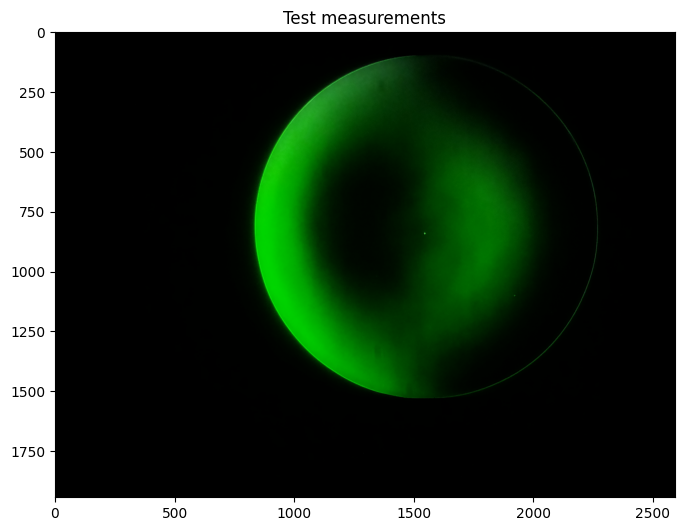

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture, cmap='gray')
  
# display that image
plt.show()

In [3]:
# convert color image into grayscale image
capture_gray = cv2.cvtColor(capture, cv2.COLOR_RGB2GRAY)

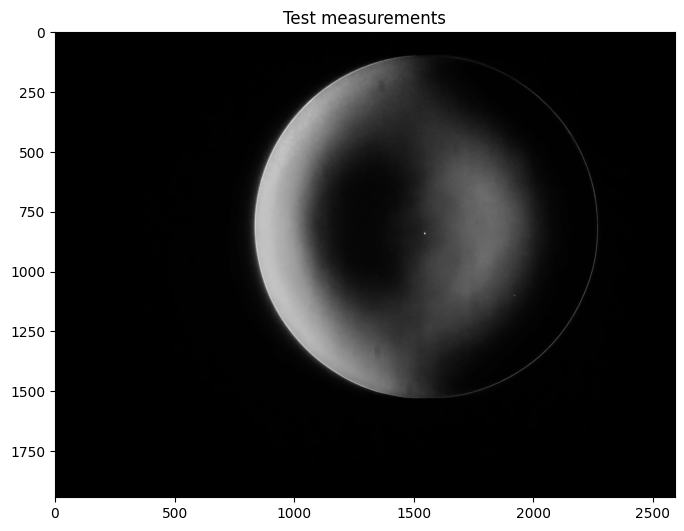

In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_gray, cmap='gray')
  
# display that image
plt.show()

TBD

In [5]:
capture_gray_blur = cv2.blur(capture_gray, (2,2))

threshold = 10
_, capture_thresh = cv2.threshold(capture_gray_blur, 10, 255, cv2.THRESH_BINARY)

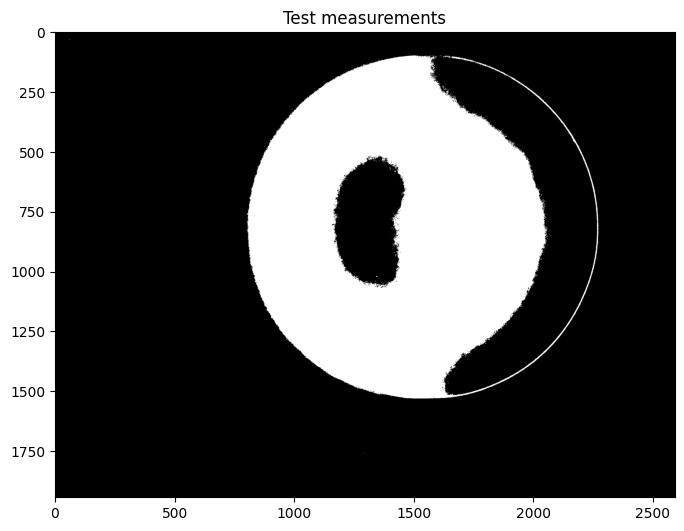

In [6]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_thresh, cmap='gray')
  
# display that image
plt.show()

In [7]:
threshold = 40
capture_canny = cv2.Canny(capture_gray_blur, threshold, threshold*2, L2gradient=True)

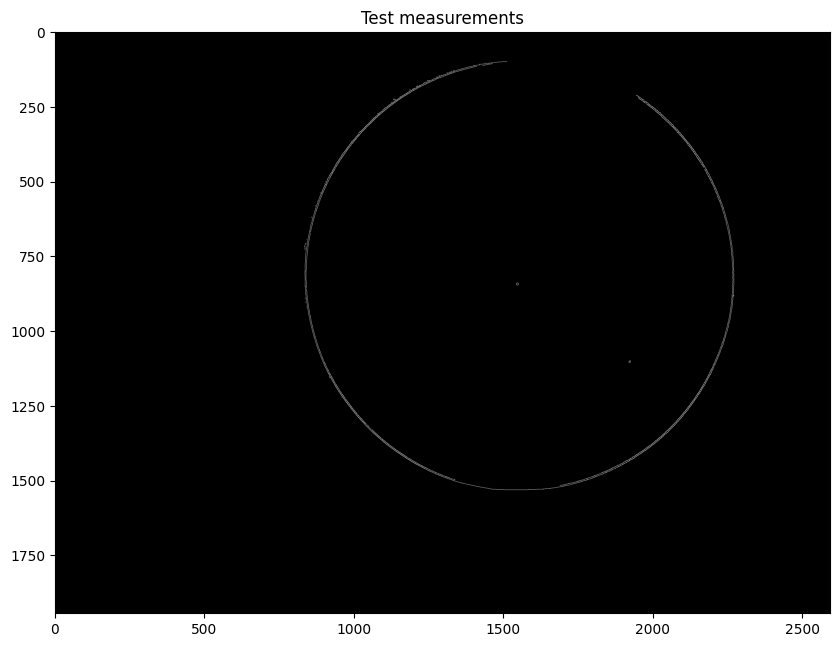

In [8]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_canny, cmap='gray')
  
# display that image
plt.show()

In [14]:
#contours, _ = cv2.findContours(capture_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#print(contours)

contours, _ = cv2.findContours(capture_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(contours)

ellipse = cv2.fitEllipse(contours[0])
#ellipse = cv2.fitEllipseAMS(contours[0])
#ellipse = cv2.fitEllipseDirect(contours[0])

color = (0,0,255)
capture_ellipse = cv2.ellipse(capture, ellipse, color, 3)


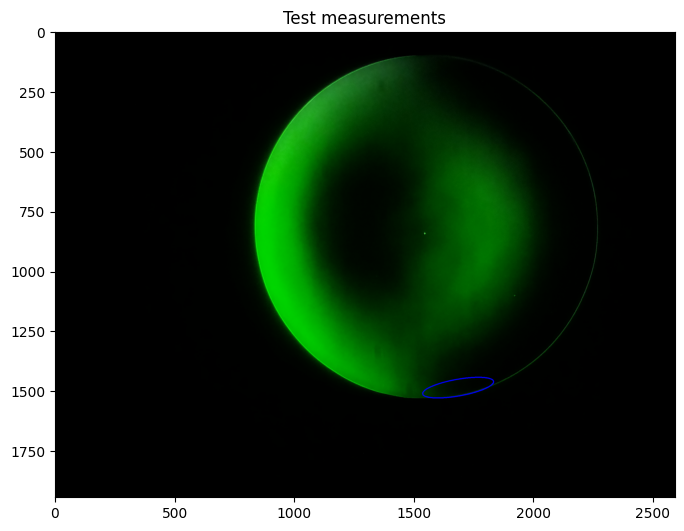

In [15]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_ellipse, cmap='gray')
#plt.imshow(capture_circles_center, cmap='gray')
  
# display that image
plt.show()

In [ ]:
capture_gray_hist = cv2.calcHist(capture_gray, [0], None, [256], [0,256])
#capture_gray_hist = cv2.calcHist(capture_gray, [0], mask, [256], [0,256])

In [ ]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.plot(capture_gray_hist)
  
# display that image
plt.show()

plt.hist(capture_gray.ravel(),256,[0,256])
plt.show()

Flip the resulting image horizontally.

In [ ]:
capture_gray_flip = cv2.flip(capture_gray, 1)

In [ ]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_gray_flip, cmap='gray')
  
# display that image
plt.show()

Subtract both original and flipped images.

In [ ]:
capture_gray_subtract = cv2.subtract(capture_gray, capture_gray_flip)

In [ ]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_gray_subtract, cmap='gray')
  
# display that image
plt.show()

Determine shadowgram radius.